# Contents
* [Overview](#Overview)
* [Imports](#Library-Imports)
* [Helper Functions](#Helper-Functions)
* [The `SchoolDistrict` Class](#The-SchoolDistrict-Class)
* [Example](#An-Example) 

# Overview
This project asks how, when faced with uncertain enrollment trends and a need to maintain a proper assignment of resources to students, a school district might set a fair resource policy by maintaining a tolerable student-to-resource ratio, for example, maintaining a certain student-to-school ratio $R$, for example 200 students in each school.

I will address this question by using a two-agent simulation of school openings and closings in a single school district, played out over 50 to 100 time steps ("school years"). One agent represents the population of public school students, which undergoes random demographic variation across years. The other agent represents the policy-making body of the district, which attempts to maintain a tolerable student-to-school ratio in the face of these demographic changes by using historical data to predict the change in enrollment at the end of each school year and opening or closing schools in response. The district administration agent will update its prediction-making method based on whether its predictions have led to good decisions (maintaining a tolerable student-to-school ratio) or poor ones (failure to maintain the ratio).

## Conceptual implementation 
I will simulate uncertain patterns of student demographic change within an individual school district; for each five-year period, the student population will (randomly) undergo either convex growth/decline, concave growth/decline, a one-time impulse of sudden inflow or outflow during the third year, or will remain flat (with uniform noise).

### Agent Behavior: District Administration
During every simulated summer, the district administration will predict the change in number of students enrolled by using an exponentially weighted moving average (EWMA) of previous year-over-year changes, then will use the prediction as a basis for action. EWMA predictions depend on a single smoothing parameter, $\alpha;\; 0<\alpha\leq1$ and larger $\alpha$ corresponds to emphasizing recent observations when predicting; see (https://otexts.com/fpp3/expsmooth.html).

The district will choose $\alpha$ randomly from the set $A = \left\{0.1,\,0.2,\,\dots,\,0.9, 1\right\}$, using the 10-vector of selection probabilities $\vec{p}$. At first, each $\alpha$ in $A$ has the same probability of being selected; each element of $\vec{p}$ is 0.1. The district will learn from its policy choice and will increase those $p_i$ that have led to predictions that led to good decisions and decrease others, a process based on the adaptive agent-specific autoregressive predictions of Arthur, 1994 (https://www.jstor.org/stable/2117868) (my model is much simpler; the reference is a multi-agent simulation in which agents compete for resources based on their predictions).

The district administration has a pre-set tolerance to violations of the student-to-school ratio; for example, if the tolerance interval is $T_\text{min}=-50\%$ to $T_\text{max}=25\%$ and the desired ratio, $R$, is 200 students per school, a predicted enrollment change resulting in $\hat{R}<100$ or $\hat{R}>250$ students per school is out-of-tolerance.
If the predicted number of students would lead to an out-of-tolerance student-to-school ratio, the number of schools will be adjusted up or down to be just within tolerance. 

# Library Imports 

In [1]:
# modeling tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint, choice
from statsmodels.tsa.api import  SimpleExpSmoothing

# programming and optimization tools
import ipdb
from collections import Counter
from dataclasses import dataclass, field
from functools import partial
from scipy.optimize import minimize_scalar


# parameters for the notebook itself
%matplotlib inline

# Helper Functions

In [2]:
def minmax_scale(data:np.array)->np.array:
    # function to scale a variable between 1 and 0, where 1 corresponds to its max value
    data = np.nan_to_num(data,0)
    vs_min = data - np.min(data)
    mmrange = np.max(data) - np.min(data) if np.max(data) != np.min(data) else 1
    scaled = vs_min / mmrange
    return scaled

In [3]:
def dbl_SEWMA(data:pd.Series, alpha:float)->dict:
    # fits a simple exponential smoothing model with fixed alpha to a dataset
    # used by simulated school (districts) to predict enrollment
    ## Arguments
    # data: univariate time series
    # alpha: exponential smoothing parameter, between 0 and 1 
    ## Returns
    # dictionary containing the sum of squared errors and statsmodels time series model
    mod1 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=alpha, optimized=False)
    return {'sse':mod1.sse, 'mod':mod1}


In [4]:
def flat_with_noise(start_value:float=10.0, n_years:int=5, chgrat:float=0.20, const_change=None)->np.array:
    # generates a set of simulated enrollments that vary due to having noise
    ## Arguments
    ## 
    ## Returns
    # np array of e
    output = np.zeros(n_years) + start_value
    chgsize = chgrat*start_value if const_change is None else const_change
    dmin = int(-1*chgsize)
    dmax = int(chgsize)
    output += np.array([randint(dmin, dmax) for x in range(n_years)],dtype=np.float64)
    return(output)

In [5]:
def impulse(start_value=10., n_years=5, impyr=2, chgrat=.670, impsign=1):
    # function to produce an impulsive change  
    chgsize = chgrat*start_value
    out = np.array([start_value for x in range(n_years)]) 
    out[impyr:n_years] = impsign*chgsize +  out[impyr]
    return(out)

In [6]:
def cvx_change(start_value=10., n_years=5, chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    chgsize = chgrat*start_value
    
    alpha = np.exp(np.log(1+chgsign*chgrat)/n_years) - 1
    output = start_value * np.power(1. + alpha, np.linspace(1,n_years,n_years))
    
    return(output)

In [7]:
def ccv_change(start_value=10.,n_years=5,alpha=0.75,chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    adjust = 0.5*np.pi if chgsign < 0 else 0
    out = np.linspace(0,0.5*np.pi, n_years+1)
    out += adjust
    maxi = (1+chgrat*chgsign)*start_value
    mini = min(start_value, maxi)
    maxi = max(start_value, maxi)
    output = (maxi-mini)*np.sin(out) + mini
    return(output[1:])

In [8]:
# with individual growth patterns defined, store all in one easy-access place
growthPats = {'flat':flat_with_noise, 
              'impUp':impulse, 
              'impDn':partial(impulse, impsign=-1), 
              'cvxUp':cvx_change, 
              'cvxDn':partial(cvx_change, chgsign=-1),
              'ccvUp':ccv_change,
              'ccvDn':partial(ccv_change, chgsign=-1)
              }

In [9]:
def simulate_history(start_value=50, total_years=50, period_length=5, debug=False, noisy=False):
    # core function to generate a school (district's) population history
    history = [[start_value for x in range(period_length)]]
            # need to add functionality to smooth the transitions 
    
    for _, tp in enumerate(range(total_years//period_length)):
        locidx = randint(0,len(growthPats)-1) # there are 7 locidxs
        lochg = history[_][period_length-1] 
        locfun = list(growthPats.values())[locidx](start_value=lochg, n_years=period_length) 
        local_h = np.squeeze(locfun)
        if noisy:
            local_h += np.squeeze(list(growthPats.values())[0](start_value=0., n_years=period_length, const_change=25.)) #TODO: use noise range ratio parameter 
        
        history.append(local_h)
        if debug:
            '''debug info that shows which growth pattern is used and prints
               the starting value and simulated values for each multiyear 
            '''
            print(f"starting history {locidx}, a/k/a {repr(list(growthPats.values())[locidx])}")
            print(_)
            print(lochg)
            print(local_h)
            print("____")

    out = np.floor(np.hstack(history)[period_length:])
    print(out)
    return out[period_length:]


In [10]:
def predict_from_history(schooldata:pd.Series,alpha_set:list=[0.1,0.5,0.7],years:int=5, random:bool=True)->dict:
    # core function to use simple exponential smoothing 
    # 
    school_SEWMA = lambda a: dbl_SEWMA(data=schooldata, alpha=a)
    fit_res = {}
    models = {}
    if random: 
        j = choice(alpha_set)
        ssmwa = school_SEWMA(j)
        fit_res[j] = ssmwa['sse']
        models[j] = ssmwa['mod']
    else:
        for j in alpha_set:
            # don't overwrite if there're multiples 
            if fit_res.get(j) is None: 
                ssmwa = school_SEWMA(j)
                fit_res[j] = ssmwa['sse']
                models[j] = ssmwa['mod']
        
    fit_check = pd.Series(fit_res)
    result = fit_check.index[fit_check.argmin()]
    return {"alpha_result":result, "prediction":models[result].forecast(years),"history":models[result].fittedvalues}

# The SchoolDistrict Class 

In [74]:
@dataclass
class SchoolDistrict:
    # core simulation class: represents the history of a single school district 
    # BASIC SIMULATION PARAMETERS (CONSTANTS)
    sscRat: int = 100 # student to school ratio
    tolerance: tuple = (-0.5, 0.25) # tolerances for that ratio
    alphas:tuple = tuple(np.linspace(0.1,0.9,9)) # starting set of exponential smoothing parameters 
    len_history:int = 60 # number of years to run the simulation
    growth_period:int = 10 # number of years to follow a particular growth patterndef simulate_history(start_value=50, total_years=50, period_length=5, debug=False):
    start_yr:int = 10 # year to begin forecasts
    noisy:bool = False # add noise to trajectory?
    # BASIC SIMULATION PARAMETERS (VARIABLE)
    NStudents:int = 1000 # initial number of students
    pred_ratios: list = field(default_factory=list) # agent-predicted student/resource ratios
    ach_ratios: list = field(default_factory=list) # achieved student/resource ratios 
    hist_alphas: list = field(default_factory=list)
    predictions: list = field(default_factory=list)
    hist_schools: list = field(default_factory=list)


    
    def simulate_full_history(self):
        # first step in the simulation--initialize the population history
        self.history=simulate_history(start_value=self.NStudents, total_years=self.len_history, period_length=self.growth_period, noisy=self.noisy)
        
    def make_construction_decisions(self,debug=True):
        # at the end of every year, make a forecast and update alpha selection probabilities
        self.NSchools = self.NStudents // (self.sscRat + self.tolerance[1])# initial number of schools--started to be near a phase transition 
        self.pselect = np.ones(len(self.alphas))/len(self.alphas) # selection probabilities for exponential smoothing parameters
        last_alpha = 0.0 # initalize the most recent choice of exponential smoothing param
        alpha_multiple, extra = divmod(self.len_history - self.start_yr, len(self.alphas)) # number of times to include an alpha in the list, 
        #--must guarantee that we won't run out of alphas
        local_as = list(self.alphas)*alpha_multiple  + [choice(self.alphas) for x in range(extra)]
        self.ach_ratios += list(np.zeros(self.start_yr)-1)
        self.predictions += list(np.zeros(self.start_yr))
        self.pred_ratios += list(np.zeros(self.start_yr))
        self.hist_alphas += list(np.zeros(self.start_yr))
        self.hist_schools += list(np.ones(self.start_yr)*self.NSchools)

        for yr in range(self.start_yr, self.len_history-self.start_yr):
            
            # calculate ratio (evaluate performance) and update list of smoothing params
            local_achrat = self.history[yr-1]/self.NSchools # achieved ratio
            self.ach_ratios.append(local_achrat)
            self.hist_schools.append(self.NSchools)
            local_diff = (local_achrat - self.sscRat)/self.sscRat # achieved difference from ideal
            if yr > self.start_yr and last_alpha in local_as:
                if local_diff > self.tolerance[1]: #achieved ratio too high
                    local_as.remove(last_alpha)
                elif local_diff < self.tolerance[0]: #achieved ratio too low
                    local_as.remove(last_alpha)
                else: # ratio ok--good prediction
                    local_as.append(last_alpha)
                    


            # forecast 
            forecast_objs = predict_from_history(self.history[0:yr],years=1,alpha_set=local_as)
            local_prat = forecast_objs['prediction'][0]/self.NSchools
            self.hist_alphas.append(forecast_objs['alpha_result'])
            last_alpha = forecast_objs['alpha_result']
            local_ach_diff = (local_prat - self.sscRat)/self.sscRat# predicted difference from ideal
            self.predictions.append(forecast_objs['prediction'][0])
            self.pred_ratios.append(local_prat)

            # update number of schools based on forecast 
            self.NSchools = np.round(self.NSchools*(1 + local_ach_diff))
            # 
            if debug:
                print(len(local_as))
                print(local_as)

    def plot_history_vs_preds(self):
        # plotting actual vs predicted enrollment
        fig, ax = plt.subplots()
        ax.plot(self.history)
        ax.plot(self.predictions)
        ax.legend(['historical','predictions'])
        ax.set_title("Time Series of Historical vs. Predicted Enrollment")
        ax.set_ylabel("# Students")
        plt.show()
        plt.close()
       

    def plot_ratios(self):
        # plotting achieved vs actual student/school ratio
        fig, ax = plt.subplots()
        ax.plot(self.ach_ratios)
        ax.plot(self.pred_ratios)
        ax.hlines((self.tolerance[0] + 1)*self.sscRat, xmin=0, xmax=self.len_history,color="gray")
        ax.hlines((self.tolerance[1] + 1)*self.sscRat, xmin=0, xmax=self.len_history,color="gray")
        ax.fill_between(range(self.len_history), 0, (self.tolerance[0] + 1)*self.sscRat, color="gray", alpha=0.30)
        ax.fill_between(range(self.len_history),(self.tolerance[1] + 1)*self.sscRat, max(max(self.ach_ratios), max(self.pred_ratios)), color="gray", alpha=0.30)
        ax.legend(['achieved','predictions'])
        ax.set_title("Time Series of Predicted vs. Achieved Student/School Ratio")
        ax.set_ylabel("Students per School")
        ax.set_xlabel("Time (Years)")
        plt.show()
        plt.close()

    def plot_schools_vs_pop(self):
        # plotting number of schools vs. population (scaled)
        fig, ax = plt.subplots()
        ax.plot(minmax_scale(simSchool.history))
        ax.plot(minmax_scale(simSchool.hist_schools))
        ax.legend(['scaled population', 'scaled # schools'])
        ax.set_title(f"Time Series of Predicted vs. Achieved Student/School Ratio\nMax #Schools:{max(self.hist_schools)}, Max Enrolled:{max(self.history)}")
        ax.set_ylabel("Scaled School Count/Scaled Enrollment")
        ax.set_xlabel("Time (Years)")
        plt.show()
        plt.close()
    
    def pct_when_performant(self, to_print=False):
        ach_test = self.ach_ratios[self.start_yr:]
        result_bool = [ (x <= ((self.tolerance[1] + 1)*self.sscRat) ) and (x >= ((self.tolerance[0] + 1)*self.sscRat)) for x in ach_test]
        prop = sum(result_bool)/len(result_bool)
        self.prop_perf = prop
        if to_print:
            print(f"The district was within tolerance bounds {np.round(100*prop,3)}% of the time.")
        return prop 
    
    

# An Example

In [75]:
simSchool = SchoolDistrict(NStudents=1250, #ini
                           sscRat=250, 
                           growth_period=10,
                           tolerance=(-.1,.1),
                           pred_ratios=[], 
                           ach_ratios=[], hist_alphas=[], predictions=[], 
                           len_history=70,noisy=False)

In [76]:
simSchool.simulate_full_history()

[1222. 1195. 1169. 1143. 1118. 1093. 1069. 1045. 1022. 1000. 1000. 1000.
  330.  330.  330.  330.  330.  330.  330.  330.  329.  326.  322.  317.
  310.  302.  293.  284.  274.  264.  263.  261.  258.  253.  248.  242.
  235.  227.  219.  211.  215.  219.  223.  227.  231.  235.  239.  244.
  248.  253.  261.  269.  276.  283.  289.  294.  298.  301.  303.  304.
  258.  354.  344.  261.  247.  260.  338.  321.  302.  319.]


In [77]:
simSchool.make_construction_decisions(debug=False)

## Plots: Population Predictions vs Actuals

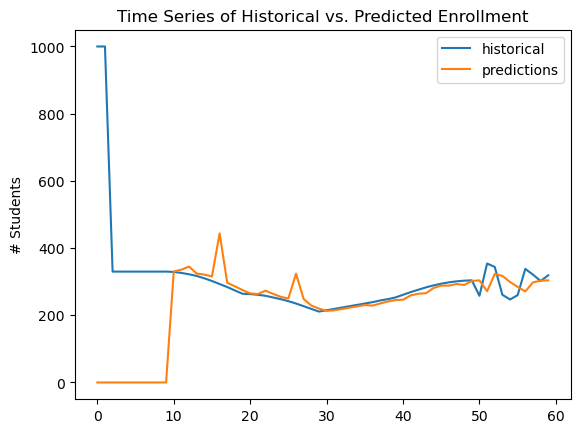

In [78]:
simSchool.plot_history_vs_preds()

## Plots: Predicted Student/School Ratios vs. Actuals

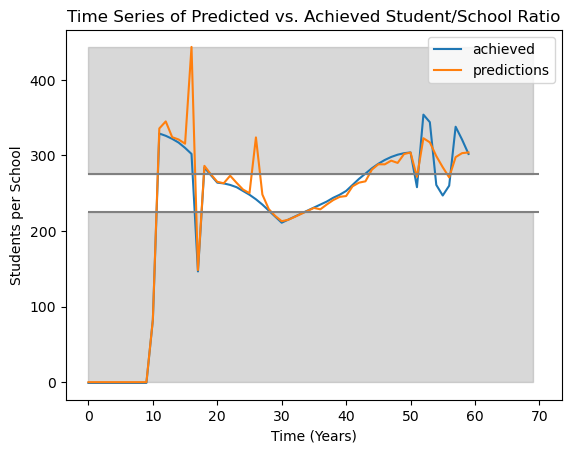

In [79]:
simSchool.plot_ratios()

## Plots: Trends in School Enrollment and Openings/Closings

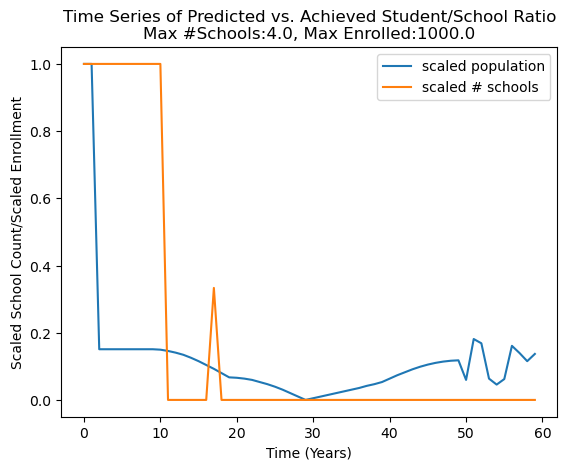

In [80]:
simSchool.plot_schools_vs_pop()

## Metrics: $\alpha$s

In [53]:
Counter(simSchool.hist_alphas)

Counter({0.4: 11,
         0.0: 10,
         0.2: 10,
         0.8: 7,
         0.5: 6,
         0.1: 5,
         0.6: 5,
         0.7000000000000001: 4,
         0.9: 1,
         0.30000000000000004: 1})

## Metrics: \% of Time Student to School Ratio is within Tolerance

In [81]:
simSchool.pct_when_performant()

0.46